In [1]:
!pip install pyrsistent matplotlib numpy -q
!pip install wandb -qU
print("✅ Libraries installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 78.3 MB/s eta 0:00:00
✅ Libraries installed!


In [2]:
import os
import sys

In [3]:
sys.path.append('/kaggle/input/senet-files')

In [4]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
from ai_pruning import AI
from evaluation_ai_star1 import SENET_AI_CONFIG
from game_state_pyrsistent import GameState
from board import create_initial_board
from rules_silent import apply_move, check_win
from sticks import throw_sticks
from datetime import datetime
import wandb

In [5]:
wandb.login(key="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")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eliasnadder (eliasnadder-liso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# إعدادات Kaggle
WORKING_DIR = "/kaggle/working"
CHECKPOINT_DIR = os.path.join(WORKING_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [7]:
# ✅ FIX: إعدادات محسّنة
POP_SIZE = 40
GENS = 50
MATCHES_PER_EVAL = 10
ELITE_SIZE = 4              # ✅ FIX: تقليل من 6
MUTATION_RATE = 0.4         # ✅ FIX: زيادة قليلاً
MAX_MOVES = 300
DIVERSITY_THRESHOLD = 2000  # ✅ FIX: جديد

In [8]:
DESIRED_CONFIG_KEYS = {
    'piece_off': 1200,
    'win_bonus': 20000,
    'progress_base': 85,
    'zone_multiplier': 1.8,
    'happiness_bonus': 150,
    'water_penalty': -300,
    'special_house': 100,
    'protection': 60,
    'block': 80,
    'attack': 60,
    'flexibility': 8,
    'isolated_penalty': 15
}

In [9]:
# ============================================================
# ✅ FIX: دوال مستقلة للـ multiprocessing
# هذه الدوال يجب أن تكون خارج الـ class ليعمل ProcessPoolExecutor
# ============================================================

def play_match_standalone(player_dna, opponent_dna, opponent_strength, max_moves=300):
    """
    ✅ FIX: دالة مستقلة للعب مباراة واحدة
    تُستدعى من ProcessPoolExecutor
    كل المعاملات تُمرر صراحة!
    """
    board = create_initial_board()
    
    ai_x = AI('X', depth=3, weights=player_dna)
    ai_o = AI('O', depth=3, weights=opponent_dna)
    
    current_player = 'X'
    move_count = 0
    state_history = {}
    
    while move_count < max_moves:
        roll = throw_sticks()
        
        if current_player == 'X':
            # اللاعب يلعب بكامل قوته دائماً
            state = GameState.from_board(board, 'X')
            move = ai_x.choose_best_move(state, roll)
        else:
            # ✅ FIX: الخصم المتكيف - يستخدم opponent_strength المُمررة
            state = GameState.from_board(board, 'O')
            
            if random.random() < opponent_strength:
                # يلعب بذكاء
                move = ai_o.choose_best_move(state, roll)
            else:
                # يلعب عشوائياً
                valid_moves = state.get_valid_moves(roll)
                move = random.choice(valid_moves) if valid_moves else None
        
        if move:
            board = apply_move(board, move[0], move[1])
            
            if check_win(board, current_player):
                return _extract_match_stats(board, current_player, move_count)
            
            board_key = tuple(board)
            state_history[board_key] = state_history.get(board_key, 0) + 1
            if state_history[board_key] >= 3:
                return _extract_match_stats(board, 'DRAW', move_count)
        
        current_player = 'O' if current_player == 'X' else 'X'
        move_count += 1
    
    # انتهى الوقت - تحديد الفائز بعدد القطع
    x_pieces = sum(1 for p in board if p == 'X')
    o_pieces = sum(1 for p in board if p == 'O')
    
    if x_pieces < o_pieces:
        winner = 'X'  # أقل قطع = أفضل (خرجت من اللوحة)
    elif o_pieces < x_pieces:
        winner = 'O'
    else:
        winner = 'DRAW'
    
    return _extract_match_stats(board, winner, move_count)


def _extract_match_stats(board, winner, moves):
    """✅ FIX: استخراج إحصائيات تفصيلية للـ Partial Credit"""
    x_positions = [i for i, p in enumerate(board) if p == 'X']
    o_positions = [i for i, p in enumerate(board) if p == 'O']
    
    x_remaining = len(x_positions)
    o_remaining = len(o_positions)
    
    # حساب التقدم
    x_avg = sum(x_positions) / len(x_positions) if x_positions else 29
    x_max = max(x_positions) if x_positions else 29
    
    return {
        'winner': winner,
        'moves': moves,
        'player_remaining': x_remaining,
        'opponent_remaining': o_remaining,
        'player_pieces_off': 7 - x_remaining,
        'opponent_pieces_off': 7 - o_remaining,
        'player_avg_progress': x_avg,
        'player_max_progress': x_max
    }


def evaluate_dna_worker(args):
    """
    ✅ FIX: Worker function للتقييم المتوازي
    كل المعاملات في tuple واحد
    """
    dna_id, dna, opponent_dna, opponent_strength, num_matches = args
    
    total_score = 0
    wins = 0
    
    for _ in range(num_matches):
        result = play_match_standalone(dna, opponent_dna, opponent_strength)
        
        # ✅ FIX: نظام نقاط محسّن مع Partial Credit
        if result['winner'] == 'X':
            total_score += 100
            wins += 1
            # مكافأة الفوز السريع
            efficiency_bonus = max(0, (MAX_MOVES - result['moves'])) * 0.15
            total_score += efficiency_bonus
        elif result['winner'] == 'DRAW':
            total_score += 35
        else:
            # حتى في الخسارة، نعطي نقاط!
            total_score += 0
        
        # ✅ FIX: Partial Credit - نقاط حتى بدون فوز!
        total_score += result['player_pieces_off'] * 15
        total_score += result['player_avg_progress'] * 2.0
        
        # الفرق في القطع المتبقية
        piece_advantage = result['opponent_remaining'] - result['player_remaining']
        total_score += piece_advantage * 10
        
        # مكافأة الوصول لمنطقة متقدمة
        if result['player_max_progress'] >= 25:
            total_score += 20
        if result['player_max_progress'] >= 28:
            total_score += 30
    
    final_score = total_score / num_matches
    return (dna_id, final_score, wins, dna)

In [10]:
# ============================================================
# المدرب الرئيسي (مُصلح)
# ============================================================

class ImprovedTrainer:
    def __init__(self, project_name="senet-ai-evolution", opponent_checkpoint=None):
        self.population = []
        self.best_ever = None
        self.best_ever_score = -float('inf')
        self.stats = {
            'best_scores': [],
            'avg_scores': [],
            'diversity': [],
            'win_rates': [],           # ✅ FIX: جديد
            'opponent_strength': []     # ✅ FIX: جديد
        }
        self.start_gen = 0

        # Self-Play settings
        self.last_opponent_update_gen = 0
        self.opponent_update_interval = 5
        self.opponent_history = []

        # ✅ FIX: Curriculum Learning - نبدأ بخصم أضعف!
        self.opponent_strength = 0.15  # كان 0.3، الآن 15% فقط!

        self.run_wandb = wandb.init(
            project=project_name,
            resume="allow",
            config={
                "pop_size": POP_SIZE,
                "gens": GENS,
                "matches_per_eval": MATCHES_PER_EVAL,
                "mutation_rate": MUTATION_RATE,
                "self_play": True,
                "initial_opponent_strength": self.opponent_strength
            }
        )

        # تحميل الخصم
        if opponent_checkpoint and os.path.exists(opponent_checkpoint):
            self.opponent_weights = self.load_opponent_from_checkpoint(opponent_checkpoint)
            print(f"✅ Loaded checkpoint as opponent")
        else:
            self.opponent_weights = SENET_AI_CONFIG.copy()
            print(f"✅ Starting with default AI opponent")
        
        print(f"🎮 Initial opponent strength: {self.opponent_strength*100:.0f}%")

    def _get_base_dna(self):
        return DESIRED_CONFIG_KEYS.copy()

    def _randomize_dna(self, base_dna=None):
        if base_dna is None:
            base_dna = self._get_base_dna()

        dna = {}
        for k, v in base_dna.items():
            factor = random.uniform(0.3, 2.0)  # ✅ FIX: زيادة التنوع
            dna[k] = v * factor
        return dna

    def _init_population(self):
        """✅ FIX: تهيئة العشيرة بتنوع أفضل"""
        print("Initializing population...")

        base = self._get_base_dna()

        # 20% بأوزان قريبة من الأصلية
        for _ in range(POP_SIZE // 5):
            dna = base.copy()
            for k in dna:
                dna[k] *= random.uniform(0.85, 1.15)
            self.population.append(dna)

        # 30% بتنوع متوسط
        for _ in range(POP_SIZE * 3 // 10):
            dna = base.copy()
            for k in dna:
                dna[k] *= random.uniform(0.5, 1.5)
            self.population.append(dna)

        # 50% بتنوع عالي
        while len(self.population) < POP_SIZE:
            self.population.append(self._randomize_dna())
        
        print(f"   Created {len(self.population)} individuals")

    def evaluate_dna(self, dna, dna_id):
        """
        ⚠️ هذه الدالة لم تعد تُستخدم مباشرة
        نستخدم evaluate_dna_worker بدلاً منها
        """
        pass

    def load_opponent_from_checkpoint(self, filepath):
        print(f"⚔️ Loading Opponent from: {filepath}")
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)

            opponent_weights = self._get_base_dna()

            if 'best_weights' in data:
                opponent_weights.update(data['best_weights'])
                print(f"   ✅ Opponent loaded with score: {data.get('best_score', 'N/A')}")
            else:
                print("   ⚠️ Warning: 'best_weights' not found. Using defaults.")

            # ✅ FIX: استعادة opponent_strength إذا موجود
            if 'opponent_strength' in data:
                # نبدأ من قيمة أقل قليلاً
                self.opponent_strength = max(0.1, data['opponent_strength'] * 0.5)
                print(f"   🎮 Adjusted opponent strength: {self.opponent_strength*100:.0f}%")

            return opponent_weights

        except FileNotFoundError:
            print(f"   ❌ File not found. Using default AI.")
            return SENET_AI_CONFIG.copy()

    # ✅ FIX: الدالة القديمة play_match لم تعد تُستخدم
    # نستخدم play_match_standalone بدلاً منها

    def _mutate(self, dna, diversity=None):
        """✅ FIX: طفرة متكيفة مع التنوع"""
        new_dna = dna.copy()

        # ✅ FIX: تعديل معدل الطفرة حسب التنوع
        if diversity is not None and diversity < DIVERSITY_THRESHOLD:
            mutation_rate = 0.6
            mutation_strength = 0.4
        else:
            mutation_rate = MUTATION_RATE
            mutation_strength = 0.25

        num_mutations = random.randint(1, 4)

        for _ in range(num_mutations):
            if random.random() < mutation_rate:
                k = random.choice(list(new_dna.keys()))

                mutation_type = random.random()

                if mutation_type < 0.5:
                    # طفرة صغيرة
                    new_dna[k] *= random.uniform(1 - mutation_strength, 1 + mutation_strength)
                elif mutation_type < 0.85:
                    # طفرة متوسطة
                    new_dna[k] *= random.uniform(0.6, 1.4)
                else:
                    # طفرة كبيرة - إعادة تعيين
                    new_dna[k] = DESIRED_CONFIG_KEYS[k] * random.uniform(0.3, 2.0)

        return new_dna

    def _crossover(self, parent1, parent2):
        child = {}

        for k in DESIRED_CONFIG_KEYS.keys():
            method = random.random()
            
            if method < 0.4:
                child[k] = parent1.get(k, DESIRED_CONFIG_KEYS[k])
            elif method < 0.8:
                child[k] = parent2.get(k, DESIRED_CONFIG_KEYS[k])
            else:
                # ✅ FIX: Blend crossover
                avg = (parent1.get(k, DESIRED_CONFIG_KEYS[k]) + 
                       parent2.get(k, DESIRED_CONFIG_KEYS[k])) / 2
                child[k] = avg * random.uniform(0.9, 1.1)

        return child

    def _calculate_diversity(self):
        if len(self.population) < 2:
            return 0

        diversities = []
        sample_size = min(20, len(self.population))
        sample = random.sample(self.population, sample_size)
        
        for i in range(len(sample)):
            for j in range(i + 1, len(sample)):
                diff = sum(abs(sample[i].get(k, 0) - sample[j].get(k, 0))
                           for k in DESIRED_CONFIG_KEYS.keys())
                diversities.append(diff)

        return np.mean(diversities) if diversities else 0

    def _tournament_select(self, results, tournament_size=5):
        """✅ FIX: Tournament Selection"""
        candidates = random.sample(results, min(tournament_size, len(results)))
        best = max(candidates, key=lambda x: x[1])
        return best[3]

    def load_checkpoint(self, filepath):
        print(f"📂 Loading checkpoint from: {filepath}")
        with open(filepath, 'r') as f:
            data = json.load(f)

        fixed_best = self._get_base_dna()
        fixed_best.update(data.get('best_weights', {}))
        self.best_ever = fixed_best
        self.best_ever_score = data.get('best_score', -float('inf'))
        self.stats = data.get('stats', {
            'best_scores': [], 'avg_scores': [], 
            'diversity': [], 'win_rates': [], 'opponent_strength': []
        })

        if 'population' in data:
            self.population = []
            for old_dna in data['population']:
                fixed_dna = self._get_base_dna()
                fixed_dna.update(old_dna)
                self.population.append(fixed_dna)
        else:
            self.population = [self.best_ever.copy() for _ in range(POP_SIZE)]

        if 'opponent_weights' in data:
            self.opponent_weights = data['opponent_weights']
        if 'last_opponent_update' in data:
            self.last_opponent_update_gen = data['last_opponent_update']
        if 'opponent_history' in data:
            self.opponent_history = data['opponent_history']
        
        # ✅ FIX: استعادة opponent_strength
        if 'opponent_strength' in data:
            self.opponent_strength = data['opponent_strength']

        self.start_gen = data['generation']

        print(f"✅ Resumed from Generation {self.start_gen}")
        print(f"   Best Score so far: {self.best_ever_score}")
        print(f"   Opponent strength: {self.opponent_strength*100:.0f}%")

    def run(self, resume_file=None):
        print("=" * 60)
        print("🧬 Self-Play Evolutionary Training (FIXED)")
        print(f"Population: {POP_SIZE}, Generations: {GENS}")
        print(f"Matches per eval: {MATCHES_PER_EVAL}")
        print(f"Initial opponent strength: {self.opponent_strength*100:.0f}%")
        print(f"Opponent updates every {self.opponent_update_interval} generations")
        print("=" * 60)

        if resume_file:
            self.load_checkpoint(resume_file)
        elif not self.population:
            self._init_population()

        for gen in range(self.start_gen, GENS):
            print(f"\n{'='*60}")
            print(f"Generation {gen + 1}/{GENS} | Opponent: {self.opponent_strength*100:.0f}%")
            print(f"{'='*60}")

            # ✅ FIX: تقييم كل العشيرة مع تمرير المعاملات صراحة
            eval_args = [
                (i, dna, self.opponent_weights.copy(), self.opponent_strength, MATCHES_PER_EVAL)
                for i, dna in enumerate(self.population)
            ]
            
            results = []
            with ProcessPoolExecutor(max_workers=4) as executor:
                futures = [executor.submit(evaluate_dna_worker, args) for args in eval_args]
                for future in as_completed(futures):
                    results.append(future.result())
                    print(f"  Evaluated {len(results)}/{len(self.population)} DNAs...", end='\r')

            print()

            # ترتيب حسب النقاط
            results.sort(key=lambda x: x[1], reverse=True)

            # إحصائيات
            scores = [r[1] for r in results]
            wins_list = [r[2] for r in results]
            
            best_score = scores[0]
            avg_score = np.mean(scores)
            worst_score = scores[-1]
            diversity = self._calculate_diversity()
            best_wins = wins_list[0]
            total_wins = sum(wins_list)

            # ✅ FIX: حساب win rates
            win_rate = best_wins / MATCHES_PER_EVAL
            pop_win_rate = total_wins / (POP_SIZE * MATCHES_PER_EVAL)

            self.stats['best_scores'].append(best_score)
            self.stats['avg_scores'].append(avg_score)
            self.stats['diversity'].append(diversity)
            self.stats['win_rates'].append(win_rate)
            self.stats['opponent_strength'].append(self.opponent_strength)

            # تحديث الأفضل على الإطلاق
            if best_score > self.best_ever_score:
                self.best_ever_score = best_score
                self.best_ever = results[0][3].copy()
                print(f"  🏆 NEW BEST EVER! Score: {best_score:.2f}")

            # ✅ FIX: طباعة محسّنة
            print(f"  📊 Best: {best_score:.2f} | Avg: {avg_score:.2f} | Worst: {worst_score:.2f}")
            print(f"  🎯 Best wins: {best_wins}/{MATCHES_PER_EVAL} ({win_rate*100:.1f}%)")
            print(f"  👥 Population wins: {total_wins}/{POP_SIZE * MATCHES_PER_EVAL} ({pop_win_rate*100:.1f}%)")
            print(f"  🧬 Diversity: {diversity:.2f}", end="")
            
            if diversity < DIVERSITY_THRESHOLD:
                print(" ⚠️ LOW!")
            else:
                print()

            # ===================================================
            # ✅ FIX: Curriculum Learning محسّن
            # ===================================================
            if (gen + 1) % self.opponent_update_interval == 0:
                # استخدام pop_win_rate بدلاً من best فقط
                if pop_win_rate >= 0.45:  # 45%+ من المجتمع يفوز
                    if self.opponent_strength < 1.0:
                        old_strength = self.opponent_strength
                        self.opponent_strength = min(1.0, self.opponent_strength + 0.12)
                        print(f"\n  📈 OPPONENT LEVEL UP! {old_strength*100:.0f}% → {self.opponent_strength*100:.0f}%")
                    
                    # تحديث أوزان الخصم عند قوة عالية
                    if self.opponent_strength >= 0.6:
                        print(f"  🔄 Updating opponent weights to current champion!")
                        self.opponent_weights = self.best_ever.copy()
                        self.opponent_history.append({
                            'gen': gen + 1,
                            'weights': self.best_ever.copy(),
                            'score': self.best_ever_score,
                            'strength': self.opponent_strength
                        })
                else:
                    print(f"\n  ⏳ Opponent update skipped (pop win rate {pop_win_rate*100:.1f}% < 45%)")
                    
                    # ✅ FIX: تخفيض الصعوبة إذا الأداء سيء جداً
                    if pop_win_rate < 0.15 and self.opponent_strength > 0.1:
                        self.opponent_strength = max(0.1, self.opponent_strength - 0.05)
                        print(f"  📉 Reducing difficulty to {self.opponent_strength*100:.0f}%")

            # ===================================================
            # إنشاء الجيل الجديد
            # ===================================================
            new_population = []

            # 1. الاحتفاظ بالنخبة
            for _, _, _, dna in results[:ELITE_SIZE]:
                new_population.append(dna.copy())

            # 2. تهجين وطفرات
            while len(new_population) < POP_SIZE - 5:  # ✅ FIX: -5 للتنوع
                # ✅ FIX: Tournament Selection
                parent1 = self._tournament_select(results)
                parent2 = self._tournament_select(results)

                child = self._crossover(parent1, parent2)

                if random.random() < MUTATION_RATE:
                    child = self._mutate(child, diversity)

                new_population.append(child)

            # ✅ FIX: 3. حقن أفراد عشوائيين للتنوع
            num_random = 7 if diversity < DIVERSITY_THRESHOLD else 5
            while len(new_population) < POP_SIZE:
                new_population.append(self._randomize_dna())

            self.population = new_population[:POP_SIZE]

            if (gen + 1) % 5 == 0:
                self._save_checkpoint(gen + 1)

        # حفظ النتيجة النهائية
        print("\n" + "=" * 60)
        print("✅ Training Complete!")
        print(f"Best score achieved: {self.best_ever_score:.2f}")
        print(f"Final opponent strength: {self.opponent_strength*100:.0f}%")
        print(f"Opponent was updated {len(self.opponent_history)} times")
        print("=" * 60)

        self._save_final_result()
        self.plot_results()

    def _save_checkpoint(self, gen):
        filename = f"checkpoint_gen_{gen}.json"
        filepath = os.path.join(CHECKPOINT_DIR, filename)

        os.makedirs(CHECKPOINT_DIR, exist_ok=True)
        data = {
            'generation': gen,
            'best_weights': self.best_ever,
            'best_score': self.best_ever_score,
            'opponent_weights': self.opponent_weights,
            'opponent_strength': self.opponent_strength,  # ✅ FIX
            'last_opponent_update': self.last_opponent_update_gen,
            'opponent_history': self.opponent_history,
            'stats': self.stats,
            'population': self.population
        }
        with open(filepath, "w") as f:
            json.dump(data, f, indent=4)

        wandb.save(filepath, base_path=WORKING_DIR)
        wandb.log({
            "gen": gen,
            "best": self.best_ever_score,
            "avg": self.stats['avg_scores'][-1],
            "diversity": self.stats['diversity'][-1],
            "win_rate": self.stats['win_rates'][-1],
            "opponent_strength": self.opponent_strength
        })
        print(f"✅ Checkpoint saved: {filename}")

    def _save_final_result(self, filename="final_model_weights.json"):
        filepath = os.path.join(WORKING_DIR, filename)

        final_data = {
            "best_weights": self.best_ever,
            "best_score": self.best_ever_score,
            "opponent_strength": self.opponent_strength,
            "opponent_history": self.opponent_history,
            "stats": self.stats,
            "generation": GENS
        }

        with open(filepath, 'w') as f:
            json.dump(final_data, f, indent=4)
        print(f"💾 Final model saved: {filepath}")

        if wandb.run is not None:
            wandb.save(filepath, base_path=WORKING_DIR)
            artifact = wandb.Artifact(name="final_model", type="model")
            artifact.add_file(filepath)
            wandb.log_artifact(artifact)
            print(f"🚀 Uploaded to WandB!")

    def plot_results(self):
        """✅ FIX: رسم محسّن"""
        plot_path = os.path.join(WORKING_DIR, "learning_curve.png")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'training_progress_{timestamp}.png'

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        generations = list(range(1, len(self.stats['best_scores']) + 1))

        # 1. النقاط
        ax1 = axes[0, 0]
        ax1.plot(generations, self.stats['best_scores'], 'b-o', label='Best', linewidth=2, markersize=4)
        ax1.plot(generations, self.stats['avg_scores'], 'g-s', label='Average', linewidth=2, markersize=4)
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Score')
        ax1.set_title('Score Evolution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. معدل الفوز
        ax2 = axes[0, 1]
        if self.stats['win_rates']:
            ax2.plot(generations, [w*100 for w in self.stats['win_rates']], 'r-^', linewidth=2)
            ax2.axhline(y=45, color='orange', linestyle='--', label='Upgrade Threshold (45%)')
        ax2.set_xlabel('Generation')
        ax2.set_ylabel('Win Rate (%)')
        ax2.set_title('Win Rate vs Opponent')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)

        # 3. التنوع
        ax3 = axes[1, 0]
        ax3.plot(generations, self.stats['diversity'], 'purple', linewidth=2)
        ax3.axhline(y=DIVERSITY_THRESHOLD, color='red', linestyle='--', label=f'Low Threshold ({DIVERSITY_THRESHOLD})')
        ax3.set_xlabel('Generation')
        ax3.set_ylabel('Diversity')
        ax3.set_title('Population Diversity')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. قوة الخصم
        ax4 = axes[1, 1]
        if self.stats['opponent_strength']:
            ax4.plot(generations, [s*100 for s in self.stats['opponent_strength']], 'orange', linewidth=2, marker='D', markersize=4)
        ax4.set_xlabel('Generation')
        ax4.set_ylabel('Opponent Strength (%)')
        ax4.set_title('Curriculum Learning Progress')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 110)

        plt.suptitle('Senet AI Training - Genetic Algorithm', fontsize=14, fontweight='bold')
        plt.tight_layout()

        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📊 Visualization saved: {filename}")

        if wandb.run is not None:
            wandb.log({"Learning Curve Plot": wandb.Image(plot_path)})
            wandb.save(plot_path)


🌱 Starting FRESH training with FIXED trainer...


wandb: Tracking run with wandb version 0.24.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20260119_142116-cvdp38es
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run glorious-pond-1
wandb: ⭐️ View project at https://wandb.ai/eliasnadder-liso/senet-ai-evolution-fixed
wandb: 🚀 View run at https://wandb.ai/eliasnadder-liso/senet-ai-evolution-fixed/runs/cvdp38es


✅ Starting with default AI opponent
🎮 Initial opponent strength: 15%
🧬 Self-Play Evolutionary Training (FIXED)
Population: 40, Generations: 50
Matches per eval: 10
Initial opponent strength: 15%
Opponent updates every 5 generations
Initializing population...
   Created 40 individuals

Generation 1/50 | Opponent: 15%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 97.35
  📊 Best: 97.35 | Avg: 69.35 | Worst: 58.34
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 2/400 (0.5%)
  🧬 Diversity: 10027.24

Generation 2/50 | Opponent: 15%
  Evaluated 40/40 DNAs...
  📊 Best: 85.59 | Avg: 71.27 | Worst: 59.50
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 5/400 (1.2%)
  🧬 Diversity: 9562.83

Generation 3/50 | Opponent: 15%
  Evaluated 40/40 DNAs...
  📊 Best: 82.86 | Avg: 68.90 | Worst: 58.81
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 3/400 (0.8%)
  🧬 Diversity: 8935.87

Generation 4/50 | Opponent: 15%
  Evaluated 40/40 DNAs...
  📊 Best: 83.90 | Avg: 70.02 | Worst: 62.74
  🎯 Best wins: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 96.16 | Avg: 70.34 | Worst: 60.49
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 4/400 (1.0%)
  🧬 Diversity: 6556.75

  ⏳ Opponent update skipped (pop win rate 1.0% < 45%)
  📉 Reducing difficulty to 10%
✅ Checkpoint saved: checkpoint_gen_5.json

Generation 6/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 84.74 | Avg: 68.45 | Worst: 53.17
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 6/400 (1.5%)
  🧬 Diversity: 9651.97

Generation 7/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 79.40 | Avg: 70.01 | Worst: 61.09
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 3/400 (0.8%)
  🧬 Diversity: 7676.59

Generation 8/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 109.13
  📊 Best: 109.13 | Avg: 69.01 | Worst: 58.44
  🎯 Best wins: 2/10 (20.0%)
  👥 Population wins: 4/400 (1.0%)
  🧬 Diversity: 7414.06

Generation 9/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 105.92 | Avg: 69.61 | Worst: 57.13
  🎯 Best wins: 

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 104.49 | Avg: 71.21 | Worst: 57.44
  🎯 Best wins: 2/10 (20.0%)
  👥 Population wins: 9/400 (2.2%)
  🧬 Diversity: 8553.99

  ⏳ Opponent update skipped (pop win rate 2.2% < 45%)
✅ Checkpoint saved: checkpoint_gen_10.json

Generation 11/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 103.82 | Avg: 67.28 | Worst: 53.64
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 4/400 (1.0%)
  🧬 Diversity: 7612.53

Generation 12/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 84.45 | Avg: 68.62 | Worst: 59.20
  🎯 Best wins: 0/10 (0.0%)
  👥 Population wins: 3/400 (0.8%)
  🧬 Diversity: 8437.83

Generation 13/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 91.51 | Avg: 70.98 | Worst: 49.54
  🎯 Best wins: 1/10 (10.0%)
  👥 Population wins: 8/400 (2.0%)
  🧬 Diversity: 9526.60

Generation 14/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 138.75
  📊 Best: 138.75 | Avg: 75.97 | Worst: 58.06
  🎯 Best wins: 4/10 (40.0%)
  👥 Populatio

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 141.97
  📊 Best: 141.97 | Avg: 95.05 | Worst: 55.11
  🎯 Best wins: 4/10 (40.0%)
  👥 Population wins: 53/400 (13.2%)
  🧬 Diversity: 5778.17

  ⏳ Opponent update skipped (pop win rate 13.2% < 45%)
✅ Checkpoint saved: checkpoint_gen_15.json

Generation 16/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 175.67
  📊 Best: 175.67 | Avg: 102.73 | Worst: 67.04
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 64/400 (16.0%)
  🧬 Diversity: 5763.62

Generation 17/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 160.30 | Avg: 98.24 | Worst: 63.51
  🎯 Best wins: 4/10 (40.0%)
  👥 Population wins: 55/400 (13.8%)
  🧬 Diversity: 2411.12

Generation 18/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 211.26
  📊 Best: 211.26 | Avg: 98.24 | Worst: 59.46
  🎯 Best wins: 6/10 (60.0%)
  👥 Population wins: 56/400 (14.0%)
  🧬 Diversity: 5358.96

Generation 19/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Bes

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 172.34 | Avg: 110.33 | Worst: 65.56
  🎯 Best wins: 4/10 (40.0%)
  👥 Population wins: 71/400 (17.8%)
  🧬 Diversity: 2988.89

  ⏳ Opponent update skipped (pop win rate 17.8% < 45%)
✅ Checkpoint saved: checkpoint_gen_20.json

Generation 21/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 162.81 | Avg: 113.76 | Worst: 60.27
  🎯 Best wins: 4/10 (40.0%)
  👥 Population wins: 76/400 (19.0%)
  🧬 Diversity: 4779.01

Generation 22/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 214.57
  📊 Best: 214.57 | Avg: 120.37 | Worst: 63.61
  🎯 Best wins: 6/10 (60.0%)
  👥 Population wins: 101/400 (25.2%)
  🧬 Diversity: 3417.37

Generation 23/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 167.97 | Avg: 104.16 | Worst: 61.05
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 61/400 (15.2%)
  🧬 Diversity: 7730.30

Generation 24/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 180.83 | Avg: 117.87 | Worst: 63.30
  🎯 Best wins: 6/10 (60

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 156.47 | Avg: 110.43 | Worst: 63.01
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 77/400 (19.2%)
  🧬 Diversity: 6917.78

  ⏳ Opponent update skipped (pop win rate 19.2% < 45%)
✅ Checkpoint saved: checkpoint_gen_25.json

Generation 26/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 202.71 | Avg: 113.17 | Worst: 67.46
  🎯 Best wins: 6/10 (60.0%)
  👥 Population wins: 73/400 (18.2%)
  🧬 Diversity: 7076.15

Generation 27/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 200.92 | Avg: 121.30 | Worst: 54.87
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 90/400 (22.5%)
  🧬 Diversity: 6763.81

Generation 28/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 200.35 | Avg: 118.87 | Worst: 58.94
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 88/400 (22.0%)
  🧬 Diversity: 6937.87

Generation 29/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 214.31 | Avg: 113.77 | Worst: 64.37
  🎯 Best wins: 7/10 (70.0%)
  👥 Population wins: 88/400 (

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 172.18 | Avg: 117.73 | Worst: 64.27
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 84/400 (21.0%)
  🧬 Diversity: 5184.48

  ⏳ Opponent update skipped (pop win rate 21.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_30.json

Generation 31/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 201.54 | Avg: 120.84 | Worst: 60.99
  🎯 Best wins: 7/10 (70.0%)
  👥 Population wins: 96/400 (24.0%)
  🧬 Diversity: 3239.37

Generation 32/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 184.80 | Avg: 118.84 | Worst: 59.87
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 92/400 (23.0%)
  🧬 Diversity: 3386.25

Generation 33/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 204.55 | Avg: 115.70 | Worst: 65.13
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 83/400 (20.8%)
  🧬 Diversity: 9299.50

Generation 34/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 167.65 | Avg: 112.70 | Worst: 65.36
  🎯 Best wins: 3/10 (30.0%)
  👥 Population wins: 78/400 (

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 221.09
  📊 Best: 221.09 | Avg: 115.15 | Worst: 64.86
  🎯 Best wins: 6/10 (60.0%)
  👥 Population wins: 80/400 (20.0%)
  🧬 Diversity: 6061.20

  ⏳ Opponent update skipped (pop win rate 20.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_35.json

Generation 36/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 177.43 | Avg: 117.79 | Worst: 63.76
  🎯 Best wins: 3/10 (30.0%)
  👥 Population wins: 85/400 (21.2%)
  🧬 Diversity: 5895.63

Generation 37/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 174.08 | Avg: 118.40 | Worst: 64.92
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 92/400 (23.0%)
  🧬 Diversity: 6211.72

Generation 38/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 162.49 | Avg: 117.42 | Worst: 62.54
  🎯 Best wins: 4/10 (40.0%)
  👥 Population wins: 87/400 (21.8%)
  🧬 Diversity: 4348.84

Generation 39/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 185.83 | Avg: 117.91 | Worst: 60.16
  🎯 Best wins: 4/10 (40.

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 211.02 | Avg: 120.36 | Worst: 64.66
  🎯 Best wins: 7/10 (70.0%)
  👥 Population wins: 93/400 (23.2%)
  🧬 Diversity: 4078.61

  ⏳ Opponent update skipped (pop win rate 23.2% < 45%)
✅ Checkpoint saved: checkpoint_gen_40.json

Generation 41/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 196.07 | Avg: 122.48 | Worst: 64.09
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 105/400 (26.2%)
  🧬 Diversity: 7268.03

Generation 42/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 182.27 | Avg: 118.38 | Worst: 64.71
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 93/400 (23.2%)
  🧬 Diversity: 3789.04

Generation 43/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 189.72 | Avg: 116.87 | Worst: 68.84
  🎯 Best wins: 4/10 (40.0%)
  👥 Population wins: 80/400 (20.0%)
  🧬 Diversity: 3612.57

Generation 44/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  🏆 NEW BEST EVER! Score: 236.63
  📊 Best: 236.63 | Avg: 125.21 | Worst: 62.29
  🎯 Best wins: 6/10 (60

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 183.62 | Avg: 124.45 | Worst: 60.40
  🎯 Best wins: 4/10 (40.0%)
  👥 Population wins: 100/400 (25.0%)
  🧬 Diversity: 6793.53

  ⏳ Opponent update skipped (pop win rate 25.0% < 45%)
✅ Checkpoint saved: checkpoint_gen_45.json

Generation 46/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 223.00 | Avg: 125.00 | Worst: 62.16
  🎯 Best wins: 6/10 (60.0%)
  👥 Population wins: 97/400 (24.2%)
  🧬 Diversity: 3670.63

Generation 47/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 178.78 | Avg: 121.77 | Worst: 65.29
  🎯 Best wins: 5/10 (50.0%)
  👥 Population wins: 102/400 (25.5%)
  🧬 Diversity: 5143.09

Generation 48/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 169.33 | Avg: 118.28 | Worst: 57.70
  🎯 Best wins: 3/10 (30.0%)
  👥 Population wins: 97/400 (24.2%)
  🧬 Diversity: 5695.96

Generation 49/50 | Opponent: 10%
  Evaluated 40/40 DNAs...
  📊 Best: 215.14 | Avg: 120.61 | Worst: 59.57
  🎯 Best wins: 6/10 (60.0%)
  👥 Population wins: 100/40

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


  Evaluated 40/40 DNAs...
  📊 Best: 199.44 | Avg: 115.90 | Worst: 62.99
  🎯 Best wins: 6/10 (60.0%)
  👥 Population wins: 87/400 (21.8%)
  🧬 Diversity: 2755.00

  ⏳ Opponent update skipped (pop win rate 21.8% < 45%)
✅ Checkpoint saved: checkpoint_gen_50.json

✅ Training Complete!
Best score achieved: 236.63
Final opponent strength: 10%
Opponent was updated 0 times
💾 Final model saved: /kaggle/working/final_model_weights.json
🚀 Uploaded to WandB!
📊 Visualization saved: training_progress_20260119_213346.png


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


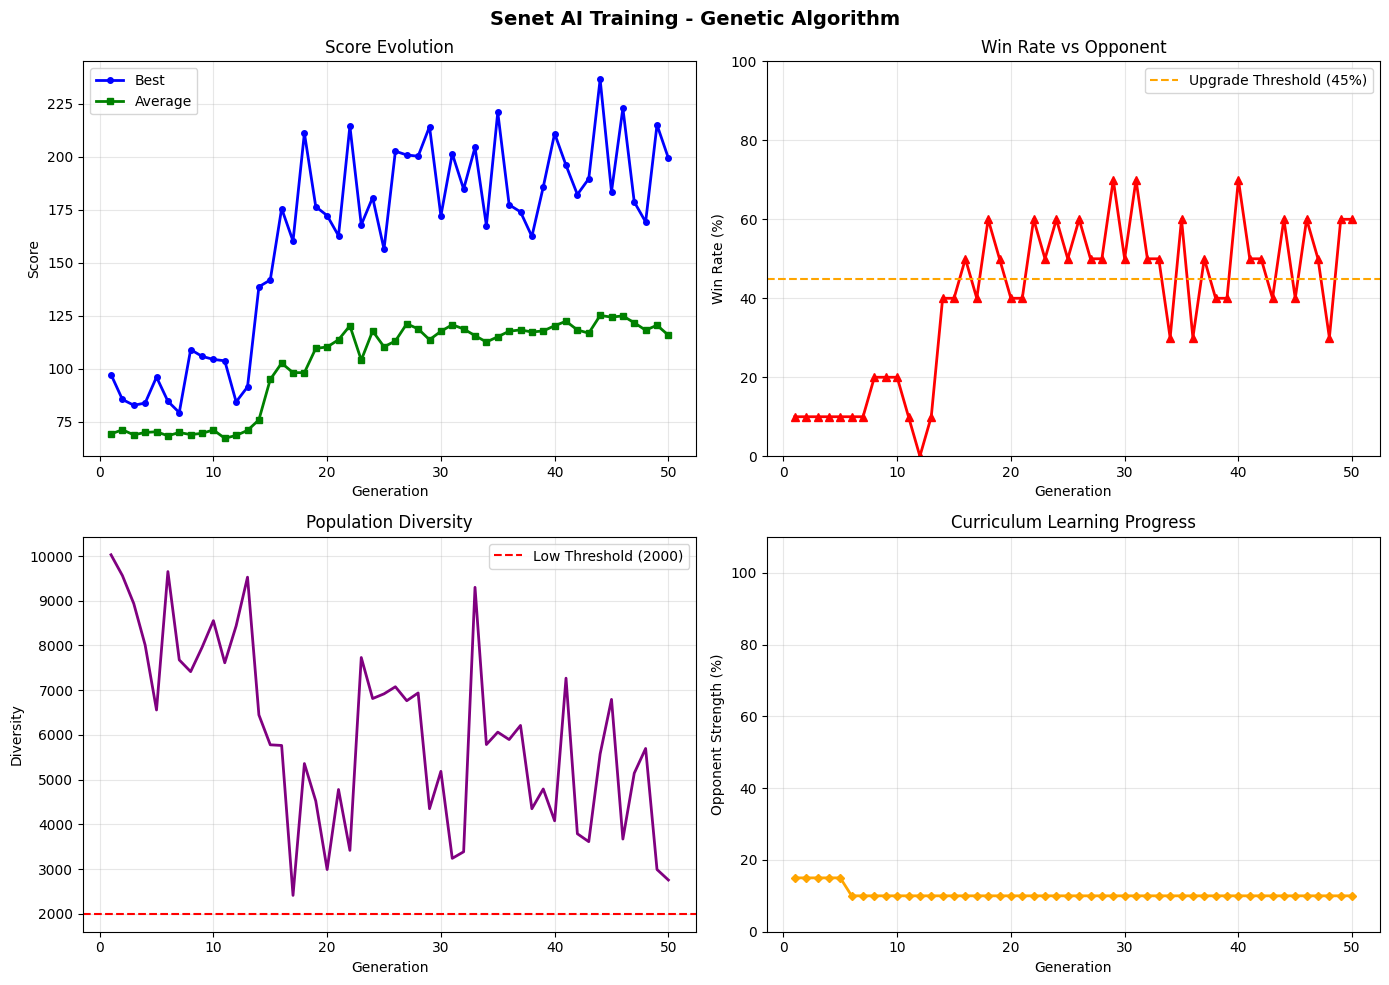

In [11]:
def get_latest_checkpoint(drive_dir):
    files = glob.glob(os.path.join(drive_dir, "checkpoint_gen_*.json"))
    if not files:
        return None
    try:
        latest_file = max(files, key=lambda f: int(f.split('_gen_')[1].split('.')[0]))
        return latest_file
    except:
        return max(files, key=os.path.getmtime)


# ============================================================
# 🚀 التشغيل
# ============================================================
if __name__ == "__main__":
    # ✅ FIX: ابدأ من جديد بدون تحميل checkpoint قديم
    # لاختبار الإصلاحات
    
    print("\n🌱 Starting FRESH training with FIXED trainer...")
    trainer = ImprovedTrainer(project_name="senet-ai-evolution-fixed")
    trainer.run(None)
    
    # أو إذا أردت الاستمرار من checkpoint:
    # latest = get_latest_checkpoint(CHECKPOINT_DIR)
    # if latest:
    #     trainer = ImprovedTrainer(project_name="senet-ai-evolution-fixed", opponent_checkpoint=latest)
    #     trainer.run(latest)

In [12]:
# class ImprovedTrainer:
#     def __init__(self, project_name="senet-ai-evolution", opponent_checkpoint=None):
#         self.population = []
#         self.best_ever = None
#         self.best_ever_score = -float('inf')
#         self.stats = {
#             'best_scores': [],
#             'avg_scores': [],
#             'diversity': []
#         }
#         self.start_gen = 0

#         # Self-Play settings
#         self.last_opponent_update_gen = 0
#         self.opponent_update_interval = 5  # كل 5 أجيال
#         self.opponent_history = []

#         self.run_wandb = wandb.init(
#             project=project_name,
#             resume="allow",
#             config={
#                 "pop_size": POP_SIZE,
#                 "gens": GENS,
#                 "matches_per_eval": MATCHES_PER_EVAL,
#                 "mutation_rate": MUTATION_RATE,
#                 "self_play": True
#             }
#         )
        
#         # تحميل الخصم
#         if opponent_checkpoint and os.path.exists(opponent_checkpoint):
#             self.opponent_weights = self.load_opponent_from_checkpoint(opponent_checkpoint)
#             print(f"✅ Loaded Gen 30 as starting opponent")
#         else:
#             # البداية من الأوزان الافتراضية
#             self.opponent_weights = SENET_AI_CONFIG.copy()
#             print(f"✅ Starting with default AI opponent")
    
#     def _get_base_dna(self):
#         """إرجاع DNA أساسي بالمفاتيح والقيم الافتراضية"""
#         return DESIRED_CONFIG_KEYS.copy()

#     def _randomize_dna(self, base_dna=None):
#         """إنشاء DNA عشوائي مع تنوع أكبر"""
#         if base_dna is None:
#             base_dna = self._get_base_dna()

#         dna = {}
#         for k, v in base_dna.items():
#             factor = random.uniform(0.5, 1.5)
#             dna[k] = v * factor
#         return dna

#     def _init_population(self):
#         """تهيئة العشيرة بتنوع أفضل"""
#         print("Initializing population...")

#         base = self._get_base_dna()

#         # 1/3 من العشيرة بأوزان قريبة من الأصلية
#         for _ in range(POP_SIZE // 3):
#             dna = base.copy()
#             for k in dna:
#                 dna[k] *= random.uniform(0.8, 1.2)
#             self.population.append(dna)

#         # 1/3 بتنوع متوسط
#         for _ in range(POP_SIZE // 3):
#             dna = base.copy()
#             for k in dna:
#                 dna[k] *= random.uniform(0.6, 1.4)
#             self.population.append(dna)

#         # 1/3 بتنوع عالي
#         for _ in range(POP_SIZE - 2 * (POP_SIZE // 3)):
#             self.population.append(self._randomize_dna())

#     def evaluate_dna(self, dna, dna_id):
#         """تقييم DNA واحد بعدة مباريات"""
#         wins = 0
#         draws = 0

#         for game_num in range(MATCHES_PER_EVAL):
#             result = self.play_match(dna)
#             if result == 'X':
#                 wins += 1
#             elif result == 'DRAW':
#                 draws += 0.5

#         # احتساب النقاط: الفوز = 3، التعادل = 1
#         score = wins * 3 + draws

#         return (dna_id, score, wins, dna)
    
#     def load_opponent_from_checkpoint(self, filepath):
#         """تحميل أوزان بطل سابق ليكون هو الخصم"""
#         print(f"⚔️ Loading Opponent from: {filepath}")
#         try:
#             with open(filepath, 'r') as f:
#                 data = json.load(f)
            
#             # نستخدم الإعدادات الافتراضية كأساس ونحدثها بأوزان الملف
#             opponent_weights = self._get_base_dna()
            
#             if 'best_weights' in data:
#                 opponent_weights.update(data['best_weights'])
#                 print(f"   ✅ Opponent loaded with score: {data.get('best_score', 'N/A')}")
#             else:
#                 print("   ⚠️ Warning: 'best_weights' not found in file. Using defaults.")
                
#             return opponent_weights
            
#         except FileNotFoundError:
#             print(f"   ❌ File not found: {filepath}. Using default AI as opponent.")
#             return SENET_AI_CONFIG.copy()

#     def play_match(self, dna):
#         """لعب مباراة واحدة ضد الخصم الحالي"""
#         board = create_initial_board()

#         # AI المدرب vs الخصم
#         ai_x = AI('X', depth=3, weights=dna)
#         ai_o = AI('O', depth=3, weights=self.opponent_weights)
        
#         current_player = 'X'
#         move_count = 0

#         # تتبع الحالات لاكتشاف التكرار
#         state_history = {}

#         while move_count < MAX_MOVES:
#             roll = throw_sticks()

#             if current_player == 'X':
#                 state = GameState.from_board(board, 'X')
#                 move = ai_x.choose_best_move(state, roll)
#             else:
#                 state = GameState.from_board(board, 'O')
#                 move = ai_o.choose_best_move(state, roll)

#             if move:
#                 board = apply_move(board, move[0], move[1])

#                 # فحص الفوز
#                 if check_win(board, current_player):
#                     return current_player

#                 # كشف التكرار
#                 board_key = tuple(board)
#                 state_history[board_key] = state_history.get(board_key, 0) + 1
#                 if state_history[board_key] >= 3:
#                     return 'DRAW'  # تعادل بسبب التكرار

#             current_player = 'O' if current_player == 'X' else 'X'
#             move_count += 1

#         # تعادل بسبب انتهاء الوقت - نحسم بعدد القطع
#         x_pieces = sum(1 for p in board if p == 'X')
#         o_pieces = sum(1 for p in board if p == 'O')

#         if x_pieces < o_pieces:
#             return 'X'  # أقل قطع = أفضل
#         elif o_pieces < x_pieces:
#             return 'O'
#         return 'DRAW'

#     def _mutate(self, dna):
#         """طفرة محسّنة مع تحكم أفضل"""
#         new_dna = dna.copy()

#         # عدد المعاملات للطفرة (1-3)
#         num_mutations = random.randint(1, 3)

#         for _ in range(num_mutations):
#             k = random.choice(list(new_dna.keys()))

#             mutation_type = random.random()

#             if mutation_type < 0.6:
#                 # طفرة صغيرة (60%)
#                 new_dna[k] *= random.uniform(0.85, 1.15)
#             elif mutation_type < 0.9:
#                 # طفرة متوسطة (30%)
#                 new_dna[k] *= random.uniform(0.7, 1.3)
#             else:
#                 # طفرة كبيرة (10%) - نادرة
#                 new_dna[k] *= random.uniform(0.5, 1.5)

#         return new_dna

#     def _crossover(self, parent1, parent2):
#         """تهجين محسّن"""
#         child = {}

#         for k in DESIRED_CONFIG_KEYS.keys():
#             if random.random() < 0.5:
#                 # أخذ من الوالد الأول
#                 child[k] = parent1.get(k, DESIRED_CONFIG_KEYS[k])
#             else:
#                 # أخذ من الوالد الثاني
#                 child[k] = parent2.get(k, DESIRED_CONFIG_KEYS[k])

#             # إضافة ضجيج صغير (10% فرصة)
#             if random.random() < 0.1:
#                 child[k] *= random.uniform(0.95, 1.05)

#         return child

#     def _calculate_diversity(self):
#         """حساب التنوع في العشيرة"""
#         if len(self.population) < 2:
#             return 0

#         diversities = []
#         for i in range(len(self.population)):
#             for j in range(i + 1, len(self.population)):
#                 diff = sum(abs(self.population[i].get(k, 0) - self.population[j].get(k, 0))
#                            for k in DESIRED_CONFIG_KEYS.keys())
#                 diversities.append(diff)

#         return np.mean(diversities) if diversities else 0

#     def _test_opponent_strength(self, opponent_weights):
#         """اختبار سريع (5 مباريات) لقوة الخصم"""
#         if self.best_ever is None:
#             return 0
            
#         wins = 0
#         for _ in range(5):
#             board = create_initial_board()
#             ai_x = AI('X', depth=3, weights=self.best_ever)
#             ai_o = AI('O', depth=3, weights=opponent_weights)
            
#             current_player = 'X'
#             move_count = 0
#             state_history = {}
            
#             while move_count < MAX_MOVES:
#                 roll = throw_sticks()
                
#                 if current_player == 'X':
#                     state = GameState.from_board(board, 'X')
#                     move = ai_x.choose_best_move(state, roll)
#                 else:
#                     state = GameState.from_board(board, 'O')
#                     move = ai_o.choose_best_move(state, roll)
                
#                 if move:
#                     board = apply_move(board, move[0], move[1])
#                     if check_win(board, current_player):
#                         if current_player == 'X':
#                             wins += 1
#                         break
                    
#                     board_key = tuple(board)
#                     state_history[board_key] = state_history.get(board_key, 0) + 1
#                     if state_history[board_key] >= 3:
#                         break
                
#                 current_player = 'O' if current_player == 'X' else 'X'
#                 move_count += 1
        
#         return wins * 3

#     def load_checkpoint(self, filepath):
#         """تحميل حالة التدريب السابقة"""
#         print(f"📂 Loading checkpoint from: {filepath}")
#         with open(filepath, 'r') as f:
#             data = json.load(f)

#         # Fix best_weights if necessary
#         fixed_best = self._get_base_dna()
#         fixed_best.update(data.get('best_weights', {}))
#         self.best_ever = fixed_best
#         self.best_ever_score = data.get('best_score', -float('inf'))
#         self.stats = data.get(
#             'stats', {'best_scores': [], 'avg_scores': [], 'diversity': []})

#         # استرجاع العشيرة (مهم جداً للاستمرار)
#         if 'population' in data:
#             self.population = []
#             for old_dna in data['population']:
#                 fixed_dna = self._get_base_dna()
#                 fixed_dna.update(old_dna)
#                 self.population.append(fixed_dna)
#         else:
#             print("⚠️ Warning: No population in checkpoint. Generating new from best weights.")
#             self.population = [self.best_ever.copy() for _ in range(POP_SIZE)]

#         # استرجاع معلومات Self-Play
#         if 'opponent_weights' in data:
#             self.opponent_weights = data['opponent_weights']
#         if 'last_opponent_update' in data:
#             self.last_opponent_update_gen = data['last_opponent_update']
#         if 'opponent_history' in data:
#             self.opponent_history = data['opponent_history']

#         self.start_gen = data['generation']

#         print(f"✅ Resumed from Generation {self.start_gen}")
#         print(f"   Best Score so far: {self.best_ever_score}")

#     def run(self, resume_file=None):
#         """تشغيل التدريب المحسّن"""
#         print("=" * 60)
#         print("🧬 Self-Play Evolutionary Training")
#         print(f"Population: {POP_SIZE}, Generations: {GENS}")
#         print(f"Matches per eval: {MATCHES_PER_EVAL}")
#         print(f"Opponent updates every {self.opponent_update_interval} generations")
#         print("=" * 60)

#         # منطق الاستئناف
#         if resume_file:
#             self.load_checkpoint(resume_file)
#         elif not self.population:
#             self._init_population()

#         for gen in range(self.start_gen, GENS):
#             print(f"\n{'='*60}")
#             print(f"Generation {gen + 1}/{GENS}")
#             print(f"{'='*60}")

#             # تقييم كل العشيرة
#             results = []
#             with ProcessPoolExecutor() as executor:
#                 futures = [executor.submit(self.evaluate_dna, dna, i)
#                            for i, dna in enumerate(self.population)]
#                 for future in as_completed(futures):
#                     results.append(future.result())
#                     print(f"  Evaluated {len(results)}/{len(self.population)} DNAs...", end='\r')

#             print()  # سطر جديد

#             # ترتيب حسب النقاط
#             results.sort(key=lambda x: x[1], reverse=True)

#             # إحصائيات
#             scores = [r[1] for r in results]
#             best_score = scores[0]
#             avg_score = np.mean(scores)
#             diversity = self._calculate_diversity()

#             self.stats['best_scores'].append(best_score)
#             self.stats['avg_scores'].append(avg_score)
#             self.stats['diversity'].append(diversity)

#             # تحديث الأفضل على الإطلاق
#             if best_score > self.best_ever_score:
#                 self.best_ever_score = best_score
#                 self.best_ever = results[0][3].copy()
#                 print(f"  🏆 NEW BEST EVER! Score: {best_score:.2f}")

#             print(f"  Best score: {best_score:.2f}")
#             print(f"  Avg score: {avg_score:.2f}")
#             print(f"  Worst score: {scores[-1]:.2f}")
#             print(f"  Diversity: {diversity:.2f}")
#             print(f"  Best DNA wins: {results[0][2]}/{MATCHES_PER_EVAL}")

#             # ===================================================
#             # 🔥 Self-Play Logic
#             # ===================================================
#             if (gen + 1) % self.opponent_update_interval == 0:
#                 # شرط: يجب أن يكون الأداء جيد قبل الترقية
#                 win_rate = best_score / (MATCHES_PER_EVAL * 3)
                
#                 if win_rate > 0.6:  # 60%+ win rate
#                     print(f"\n🚀 OPPONENT LEVEL UP!")
#                     old_strength = self._test_opponent_strength(self.opponent_weights)
#                     print(f"   Old opponent strength: {old_strength:.1f}")
                    
#                     # الترقية: الخصم الجديد = البطل الحالي
#                     self.opponent_weights = self.best_ever.copy()
#                     self.last_opponent_update_gen = gen + 1
                    
#                     self.opponent_history.append({
#                         'gen': gen + 1,
#                         'weights': self.best_ever.copy(),
#                         'score': self.best_ever_score
#                     })
                    
#                     new_strength = self._test_opponent_strength(self.opponent_weights)
#                     print(f"   New opponent (Gen {gen+1} Champion) strength: {new_strength:.1f}")
#                     print(f"   🎯 Now training against itself!")
#                 else:
#                     print(f"\n⏳ Opponent update skipped (win rate {win_rate*100:.1f}% < 60%)")
#                     print(f"   Population needs more evolution")
#             # ===================================================

#             # إنشاء الجيل الجديد
#             new_population = []

#             # 1. الاحتفاظ بالنخبة
#             for _, _, _, dna in results[:ELITE_SIZE]:
#                 new_population.append(dna.copy())

#             # 2. تهجين وطفرات
#             while len(new_population) < POP_SIZE:
#                 # اختيار والدين من أفضل 50%
#                 parent1 = random.choice([r[3] for r in results[:POP_SIZE//2]])
#                 parent2 = random.choice([r[3] for r in results[:POP_SIZE//2]])

#                 # تهجين
#                 child = self._crossover(parent1, parent2)

#                 # طفرة
#                 if random.random() < MUTATION_RATE:
#                     child = self._mutate(child)

#                 new_population.append(child)

#             self.population = new_population
            
#             if (gen + 1) % 5 == 0:
#                 self._save_checkpoint(gen + 1)

#         # حفظ النتيجة النهائية
#         print("\n" + "=" * 60)
#         print("✅ Training Complete!")
#         print(f"Best score achieved: {self.best_ever_score:.2f}")
#         print(f"Opponent was updated {len(self.opponent_history)} times")
#         print("=" * 60)

#         self._save_final_result()
#         self.plot_results()

#     def _save_checkpoint(self, gen):
#         """حفظ نقطة تفتيش"""
#         filename = f"checkpoint_gen_{gen}.json"
#         filepath = os.path.join(CHECKPOINT_DIR, filename)

#         os.makedirs(CHECKPOINT_DIR, exist_ok=True)
#         data = {
#             'generation': gen,
#             'best_weights': self.best_ever,
#             'best_score': self.best_ever_score,
#             'opponent_weights': self.opponent_weights,
#             'last_opponent_update': self.last_opponent_update_gen,
#             'opponent_history': self.opponent_history,
#             'stats': self.stats,
#             'population': self.population
#         }
#         with open(filepath, "w") as f:
#             json.dump(data, f, indent=4)

#         wandb.save(filepath, base_path=WORKING_DIR)
#         wandb.log({
#             "gen": gen,
#             "best": self.best_ever_score,
#             "avg": self.stats['avg_scores'][-1],
#             "diversity": self.stats['diversity'][-1],
#             "opponent_updates": len(self.opponent_history)
#         })
#         print(f"✅ Checkpoint saved: {filename}")

#     def _save_final_result(self, filename="final_model_weights.json"):
#         filepath = os.path.join(WORKING_DIR, filename)

#         final_data = {
#             "best_weights": self.best_ever,
#             "best_score": self.best_ever_score,
#             "opponent_history": self.opponent_history,
#             "stats": self.stats,
#             "generation": GENS
#         }

#         with open(filepath, 'w') as f:
#             json.dump(final_data, f, indent=4)
#         print(f"💾 Final model saved: {filepath}")

#         if wandb.run is not None:
#             wandb.save(filepath, base_path=WORKING_DIR)
#             artifact = wandb.Artifact(name="final_model", type="model")
#             artifact.add_file(filepath)
#             wandb.log_artifact(artifact)
#             print(f"🚀 Uploaded to WandB!")
            
#     def plot_results(self):
#         """رسم النتائج مع مقارنة بالتدريب السابق"""
#         plot_path = os.path.join(WORKING_DIR, "learning_curve.png")
#         # محاولة تحميل النتائج السابقة
#         previous_stats = self._load_previous_stats()

#         # إنشاء اسم الملف مع التاريخ والوقت
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         filename = f'training_progress_{timestamp}.png'

#         # تحديد حجم الرسم بناءً على وجود بيانات سابقة
#         if previous_stats:
#             fig = plt.figure(figsize=(16, 12))
#             gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
#         else:
#             fig = plt.figure(figsize=(14, 10))
#             gs = fig.add_gridspec(3, 1, hspace=0.3)

#         # ========== الرسم 1: تقدم النقاط ==========
#         if previous_stats:
#             ax1 = fig.add_subplot(gs[0, :])
#         else:
#             ax1 = fig.add_subplot(gs[0, 0])

#         # رسم النتائج الحالية
#         generations = list(range(1, len(self.stats['best_scores']) + 1))

#         ax1.plot(generations, self.stats['best_scores'],
#                  label='Best Score (Current)', linewidth=2.5,
#                  marker='o', markersize=4, color='#2E86AB')
#         ax1.plot(generations, self.stats['avg_scores'],
#                  label='Average Score (Current)', linewidth=2.5,
#                  marker='s', markersize=4, color='#A23B72')

#         # رسم النتائج السابقة إذا وجدت
#         if previous_stats and 'best_scores' in previous_stats:
#             prev_gens = list(range(1, len(previous_stats['best_scores']) + 1))
#             ax1.plot(prev_gens, previous_stats['best_scores'],
#                      label='Best Score (Previous)', linewidth=2,
#                      linestyle='--', alpha=0.6, color='#2E86AB')
#             ax1.plot(prev_gens, previous_stats['avg_scores'],
#                      label='Average Score (Previous)', linewidth=2,
#                      linestyle='--', alpha=0.6, color='#A23B72')

#         ax1.set_xlabel('Generation', fontsize=11, fontweight='bold')
#         ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
#         ax1.set_title('Training Progress - Score Evolution',
#                       fontsize=13, fontweight='bold', pad=15)
#         ax1.legend(loc='best', fontsize=9)
#         ax1.grid(True, alpha=0.3, linestyle='--')
#         ax1.set_xlim(left=0)

#         # إضافة خط أفقي للأفضل على الإطلاق
#         ax1.axhline(y=self.best_ever_score, color='gold',
#                     linestyle=':', linewidth=2, alpha=0.7,
#                     label=f'Best Ever: {self.best_ever_score:.2f}')

#         # ========== الرسم 2: التنوع ==========
#         if previous_stats:
#             ax2 = fig.add_subplot(gs[1, 0])
#         else:
#             ax2 = fig.add_subplot(gs[1, 0])

#         ax2.plot(generations, self.stats['diversity'],
#                  label='Diversity (Current)', linewidth=2.5,
#                  color='#06A77D', marker='^', markersize=4)

#         if previous_stats and 'diversity' in previous_stats:
#             prev_gens = list(range(1, len(previous_stats['diversity']) + 1))
#             ax2.plot(prev_gens, previous_stats['diversity'],
#                      label='Diversity (Previous)', linewidth=2,
#                      linestyle='--', alpha=0.6, color='#06A77D')

#         ax2.set_xlabel('Generation', fontsize=11, fontweight='bold')
#         ax2.set_ylabel('Diversity Score', fontsize=11, fontweight='bold')
#         ax2.set_title('Population Diversity Over Time',
#                       fontsize=13, fontweight='bold', pad=15)
#         ax2.legend(loc='best', fontsize=9)
#         ax2.grid(True, alpha=0.3, linestyle='--')
#         ax2.set_xlim(left=0)

#         # ========== الرسم 3: معدل التحسن ==========
#         if previous_stats:
#             ax3 = fig.add_subplot(gs[1, 1])
#         else:
#             ax3 = fig.add_subplot(gs[2, 0])

#         # حساب معدل التحسن بين الأجيال
#         if len(self.stats['best_scores']) > 1:
#             improvements = [self.stats['best_scores'][i] - self.stats['best_scores'][i-1]
#                             for i in range(1, len(self.stats['best_scores']))]

#             improvement_gens = list(
#                 range(2, len(self.stats['best_scores']) + 1))

#             colors = ['green' if imp > 0 else 'red' if imp < 0 else 'gray'
#                       for imp in improvements]

#             ax3.bar(improvement_gens, improvements,
#                     color=colors, alpha=0.7, width=0.8)
#             ax3.set_xlabel('Generation', fontsize=11, fontweight='bold')
#             ax3.set_ylabel('Score Improvement', fontsize=11, fontweight='bold')
#             ax3.set_title('Generation-to-Generation Improvement',
#                           fontsize=13, fontweight='bold', pad=15)
#             ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
#             ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
#             ax3.set_xlim(left=1)

#         # ========== الرسم 4: مقارنة الأوزان (إذا وجدت نتائج سابقة) ==========
#         if previous_stats and 'final_weights' in previous_stats:
#             ax4 = fig.add_subplot(gs[2, :])

#             weight_keys = list(DESIRED_CONFIG_KEYS.keys())
#             x = np.arange(len(weight_keys))
#             width = 0.35

#             current_vals = [self.best_ever.get(k, 0) for k in weight_keys]
#             previous_vals = [previous_stats['final_weights'].get(
#                 k, 0) for k in weight_keys]

#             ax4.bar(x - width/2, previous_vals, width,
#                     label='Previous Best', alpha=0.7, color='#95B8D1')
#             ax4.bar(x + width/2, current_vals, width,
#                     label='Current Best', alpha=0.7, color='#E09F3E')

#             ax4.set_xlabel('Weight Parameters')
#             ax4.set_ylabel('Weight Value')
#             ax4.set_title('Final Weights Comparison: Previous vs Current')
#             ax4.set_xticks(x)
#             ax4.set_xticklabels(weight_keys, rotation=45, ha='right')
#             ax4.legend(loc='best')
#             ax4.grid(True, alpha=0.3, axis='y')
#             ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

#             for bars in ax4.containers:
#                 for bar in bars:
#                     height = bar.get_height()
#                     if abs(height) > 10:
#                         ax4.text(bar.get_x() + bar.get_width()/2., height,
#                                  f'{height:.0f}', ha='center',
#                                  va='bottom' if height > 0 else 'top', fontsize=7, alpha=0.7)

#         info_text = f"""Training Configuration:
# Population Size: {POP_SIZE}
# Generations: {GENS}
# Matches per Eval: {MATCHES_PER_EVAL}
# Best Score: {self.best_ever_score:.2f}
# Final Avg Score: {self.stats['avg_scores'][-1]:.2f if self.stats['avg_scores'] else 0:.2f}
# Date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}"""

#         fig.text(0.02, 0.02, info_text, fontsize=8, family='monospace',
#                  verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

#         plt.suptitle('Senet AI Training Results - Genetic Algorithm Evolution',
#                      fontsize=16, fontweight='bold', y=0.995)

#         plt.savefig(filename, dpi=300, bbox_inches='tight')
#         print(f"  📊 Visualization saved: {filename}")

#         plt.savefig(plot_path)
#         print(f"  📊 Latest copy saved: {latest_filename}")

#         if wandb.run is not None:
#             # رفعه كصورة في لوحة التحكم (Dashboard)
#             wandb.log({"Learning Curve Plot": wandb.Image(plot_path)})
#             # رفعه كملف في قسم Files
#             wandb.save(plot_path)

In [13]:
# def get_latest_checkpoint(drive_dir):
#   files = glob.glob(os.path.join(drive_dir, "checkpoint_gen_*.json"))
#   if not files:
#       return None
#   # استخراج رقم الجيل من اسم الملف للترتيب الصحيح
#   # المتوقع: checkpoint_gen_10.json
#   try:
#       latest_file = max(files, key=lambda f: int(
#           f.split('_gen_')[1].split('.')[0]))
#       return latest_file
#   except:
#       return max(files, key=os.path.getmtime)

In [14]:
# def auto_fetch_latest_checkpoint(entity="eliasnadder-liso", project="senet-ai-evolution"):
#     """
#     دالة ذكية تبحث تلقائياً عن آخر ملف حفظ في السحابة (WandB)
#     وإذا لم تجد، تبحث في الجهاز المحلي.
#     """
#     print(f"\n🔄 Auto-scanning for latest checkpoints...")

#     # 1. محاولة البحث في WandB (السحابة)
#     try:
#         api = wandb.Api()
#         # جلب الـ runs مرتبة من الأحدث للأقدم
#         runs = api.runs(f"{entity}/{project}", order="-created_at")

#         if runs:
#             print(f"   Connected to WandB. Scanning {len(runs)} runs...")

#             # البحث في أحدث 5 محاولات فقط لتوفير الوقت
#             for run in runs[:5]:
#                 files = [f for f in run.files() if "checkpoint_gen_" in f.name and f.name.endswith(".json")]

#                 if files:
#                     # العثور على الملف ذو الرقم الأكبر (أحدث جيل)
#                     latest_file = max(files, key=lambda f: int(f.name.split('_gen_')[1].split('.')[0]))

#                     print(f"   ⬇️  Found cloud checkpoint: Run '{run.name}' -> Gen {latest_file.name}")
#                     downloaded = latest_file.download(root=WORKING_DIR, replace=True)
#                     return downloaded.name
#     except Exception as e:
#         print(f"   ⚠️  Could not fetch from WandB: {e}")

#     # 2. محاولة البحث محلياً (Fallback)
#     print("   Checking local disk...")
#     local_checkpoint = get_latest_checkpoint(CHECKPOINT_DIR)

#     if local_checkpoint:
#         print(f"   📂 Found local checkpoint: {os.path.basename(local_checkpoint)}")
#         return local_checkpoint

#     return None

In [15]:
# if __name__ == "__main__":
#     # تهيئة المدرب

#     # البحث التلقائي عن آخر نقطة حفظ (سحابياً أو محلياً)
#     latest_checkpoint = auto_fetch_latest_checkpoint()
    
#     if latest_checkpoint:
#         print(f"\n🚀 AUTOMATIC RESTART: Resuming from {os.path.basename(latest_checkpoint)}")
#         trainer = ImprovedTrainer(project_name="senet-ai-evolution", opponent_checkpoint=latest_checkpoint)
#         trainer.run(None)
#         # مثال:
#         # تشغيل التدريب مباشرة بالملف المحمل
#         # الدالة run في الكلاس الخاص بك تتعامل تلقائياً مع تحميل الملف واستكمال الجيل
#         # trainer.run(latest_checkpoint)
        
#     else:
#         print("\n🌱 No history found. Starting FRESH training...")
#         trainer.run(None)

In [16]:
# class ImprovedTrainer:
#     def __init__(self, project_name="senet-ai-evolution", opponent_checkpoint=None):
#         self.population = []
#         self.best_ever = None
#         self.best_ever_score = -float('inf')
#         self.stats = {
#             'best_scores': [],
#             'avg_scores': [],
#             'diversity': []
#         }
#         self.start_gen = 0

#         self.run_wandb = wandb.init(
#             project=project_name,
#             resume="allow",
#             config={
#                 "pop_size": POP_SIZE,
#                 "gens": GENS,
#                 "matches_per_eval": MATCHES_PER_EVAL,
#                 "mutation_rate": MUTATION_RATE
#             }
#         )
#         if opponent_checkpoint and os.path.exists(opponent_checkpoint):
#             # إذا حددنا ملفاً، نحمل الأوزان منه
#             self.opponent_weights = self.load_opponent_from_checkpoint(opponent_checkpoint)
#         else:
#             # إذا لم نحدد ملفاً، الخصم هو الإعدادات الافتراضية (الضعيفة)
#             self.opponent_weights = SENET_AI_CONFIG.copy()
    
#     def _get_base_dna(self):
#         """إرجاع DNA أساسي بالمفاتيح والقيم الافتراضية المطلوبة بالضبط"""
#         return DESIRED_CONFIG_KEYS.copy()

#     def _randomize_dna(self, base_dna=None):
#         """إنشاء DNA عشوائي مع تنوع أفضل"""
#         if base_dna is None:
#             base_dna = self._get_base_dna()

#         dna = {}
#         for k, v in base_dna.items():
#             # تنوع أكبر في البداية
#             factor = random.uniform(0.5, 1.5)
#             dna[k] = v * factor
#         return dna

#     def _init_population(self):
#         """تهيئة العشيرة بتنوع أفضل"""
#         print("Initializing population...")

#         base = self._get_base_dna()

#         # 1/3 من العشيرة بأوزان قريبة من الأصلية
#         for _ in range(POP_SIZE // 3):
#             dna = base.copy()
#             for k in dna:
#                 dna[k] *= random.uniform(0.8, 1.2)
#             self.population.append(dna)

#         # 1/3 بتنوع متوسط
#         for _ in range(POP_SIZE // 3):
#             dna = base.copy()
#             for k in dna:
#                 dna[k] *= random.uniform(0.6, 1.4)
#             self.population.append(dna)

#         # 1/3 بتنوع عالي
#         for _ in range(POP_SIZE - 2 * (POP_SIZE // 3)):
#             self.population.append(self._randomize_dna())

#     def evaluate_dna(self, dna, dna_id):
#         """تقييم DNA واحد بعدة مباريات"""
#         wins = 0
#         draws = 0

#         for game_num in range(MATCHES_PER_EVAL):
#             result = self.play_match(dna)
#             if result == 'X':
#                 wins += 1
#             elif result == 'DRAW':
#                 draws += 0.5

#         # احتساب النقاط: الفوز = 3، التعادل = 1
#         score = wins * 3 + draws

#         return (dna_id, score, wins, dna)
    
#     def load_opponent_from_checkpoint(self, filepath):
#         """تحميل أوزان بطل سابق ليكون هو الخصم"""
#         print(f"⚔️ Loading Opponent (Champion) from: {filepath}")
#         try:
#             with open(filepath, 'r') as f:
#                 data = json.load(f)
            
#             # نستخدم الإعدادات الافتراضية كأساس ونحدثها بأوزان الملف
#             # لضمان عدم وجود مفاتيح ناقصة
#             opponent_weights = self._get_base_dna() # أو SENET_AI_CONFIG.copy()
            
#             if 'best_weights' in data:
#                 opponent_weights.update(data['best_weights'])
#                 print(data['best_weights'])
#                 print(f"   ✅ Opponent loaded with score: {data.get('best_score', 'N/A')}")
#             else:
#                 print("   ⚠️ Warning: 'best_weights' not found in file. Using defaults.")
                
#             return opponent_weights
            
#         except FileNotFoundError:
#             print(f"   ❌ File not found: {filepath}. Using default AI as opponent.")
#             return SENET_AI_CONFIG.copy()

#     def play_match(self, dna):
#         """لعب مباراة واحدة"""
#         board = create_initial_board()

#         # AI المدرب vs AI الأساسي
#         ai_x = AI('X', depth=3, weights=dna)
#         ai_o = AI('O', depth=3, weights=self.opponent_weights)
        
#         current_player = 'X'
#         move_count = 0

#         # تتبع الحالات لاكتشاف التكرار
#         state_history = {}

#         while move_count < MAX_MOVES:
#             roll = throw_sticks()

#             if current_player == 'X':
#                 state = GameState.from_board(board, 'X')
#                 move = ai_x.choose_best_move(state, roll)
#             else:
#                 state = GameState.from_board(board, 'O')
#                 move = ai_o.choose_best_move(state, roll)

#             if move:
#                 board = apply_move(board, move[0], move[1])

#                 # فحص الفوز
#                 if check_win(board, current_player):
#                     return current_player

#                 # كشف التكرار
#                 board_key = tuple(board)
#                 state_history[board_key] = state_history.get(board_key, 0) + 1
#                 if state_history[board_key] >= 3:
#                     return 'DRAW'  # تعادل بسبب التكرار

#             current_player = 'O' if current_player == 'X' else 'X'
#             move_count += 1

#         # تعادل بسبب انتهاء الوقت
#         x_pieces = sum(1 for p in board if p == 'X')
#         o_pieces = sum(1 for p in board if p == 'O')

#         if x_pieces < o_pieces:
#             return 'X'  # أقل قطع = أفضل
#         elif o_pieces < x_pieces:
#             return 'O'
#         return 'DRAW'

#     def _mutate(self, dna):
#         """طفرة محسّنة مع تحكم أفضل"""
#         new_dna = dna.copy()

#         # عدد المعاملات للطفرة
#         num_mutations = random.randint(1, 3)

#         for _ in range(num_mutations):
#             k = random.choice(list(new_dna.keys()))

#             mutation_type = random.random()

#             if mutation_type < 0.6:
#                 # طفرة صغيرة
#                 new_dna[k] *= random.uniform(0.85, 1.15)
#             elif mutation_type < 0.9:
#                 # طفرة متوسطة
#                 new_dna[k] *= random.uniform(0.7, 1.3)
#             else:
#                 # طفرة كبيرة (نادرة)
#                 new_dna[k] *= random.uniform(0.5, 1.5)

#         return new_dna

#     def _crossover(self, parent1, parent2):
#         """تهجين محسّن"""
#         child = {}

#         for k in DESIRED_CONFIG_KEYS.keys():
#             if random.random() < 0.5:
#                 # أخذ من الوالد الأول
#                 child[k] = parent1.get(k, DESIRED_CONFIG_KEYS[k])
#             else:
#                 # أخذ من الوالد الثاني
#                 child[k] = parent2.get(k, DESIRED_CONFIG_KEYS[k])

#             # إضافة ضجيج صغير
#             if random.random() < 0.1:
#                 child[k] *= random.uniform(0.95, 1.05)

#         return child

#     def _calculate_diversity(self):
#         """حساب التنوع في العشيرة"""
#         if len(self.population) < 2:
#             return 0

#         diversities = []
#         for i in range(len(self.population)):
#             for j in range(i + 1, len(self.population)):
#                 diff = sum(abs(self.population[i].get(k, 0) - self.population[j].get(k, 0))
#                            for k in DESIRED_CONFIG_KEYS.keys())
#                 diversities.append(diff)

#         return np.mean(diversities) if diversities else 0

#     def load_checkpoint(self, filepath):
#         """تحميل حالة التدريب السابقة"""
#         print(f"📂 Loading checkpoint from: {filepath}")
#         with open(filepath, 'r') as f:
#             data = json.load(f)

#         # Fix best_weights if necessary
#         fixed_best = self._get_base_dna()
#         fixed_best.update(data.get('best_weights', {}))
#         self.best_ever = fixed_best
#         self.best_ever_score = data.get('best_score', -float('inf'))
#         self.stats = data.get(
#             'stats', {'best_scores': [], 'avg_scores': [], 'diversity': []})

#         # استرجاع العشيرة (مهم جداً للاستمرار)
#         if 'population' in data:
#             self.population = []
#             for old_dna in data['population']:
#                 fixed_dna = self._get_base_dna()
#                 fixed_dna.update(old_dna)
#                 self.population.append(fixed_dna)
#         else:
#             print(
#                 "⚠️ Warning: No population in checkpoint. Generating new from best weights.")
#             self.population = [self.best_ever.copy() for _ in range(POP_SIZE)]

#         self.start_gen = data['generation']

#         print(f"✅ Resumed from Generation {self.start_gen}")
#         print(f"   Best Score so far: {self.best_ever_score}")

#     def run(self, resume_file=None):
#         """تشغيل التدريب المحسّن"""
#         print("=" * 60)
#         print("Starting Improved Evolutionary Training")
#         print(f"Population: {POP_SIZE}, Generations: {GENS}")
#         print(f"Matches per eval: {MATCHES_PER_EVAL}")
#         print("=" * 60)

#         # منطق الاستئناف
#         if resume_file:
#             self.load_checkpoint(resume_file)
#         elif not self.population:
#             self._init_population()

#         for gen in range(self.start_gen, GENS):
#             print(f"\n{'='*60}")
#             print(f"Generation {gen + 1}/{GENS}")
#             print(f"{'='*60}")

#             # تقييم كل العشيرة
#             results = []
#             with ProcessPoolExecutor() as executor:
#                 futures = [executor.submit(self.evaluate_dna, dna, i)
#                            for i, dna in enumerate(self.population)]
#                 for future in as_completed(futures):
#                     results.append(future.result())
#                     print(
#                         f"  Evaluated {len(results)}/{len(self.population)} DNAs...", end='\r')

#             print()  # سطر جديد

#             # ترتيب حسب النقاط
#             results.sort(key=lambda x: x[1], reverse=True)

#             # إحصائيات
#             scores = [r[1] for r in results]
#             best_score = scores[0]
#             avg_score = np.mean(scores)
#             diversity = self._calculate_diversity()

#             self.stats['best_scores'].append(best_score)
#             self.stats['avg_scores'].append(avg_score)
#             self.stats['diversity'].append(diversity)

#             # تحديث الأفضل على الإطلاق
#             if best_score > self.best_ever_score:
#                 self.best_ever_score = best_score
#                 self.best_ever = results[0][3].copy()
#                 print(f"  🏆 NEW BEST EVER! Score: {best_score:.2f}")

#             print(f"  Best score: {best_score:.2f}")
#             print(f"  Avg score: {avg_score:.2f}")
#             print(f"  Worst score: {scores[-1]:.2f}")
#             print(f"  Diversity: {diversity:.2f}")
#             print(f"  Best DNA wins: {results[0][2]}/{MATCHES_PER_EVAL}")

#             # إنشاء الجيل الجديد
#             new_population = []

#             # 1. الاحتفاظ بالنخبة
#             for _, _, _, dna in results[:ELITE_SIZE]:
#                 new_population.append(dna.copy())

#             # 2. تهجين وطفرات
#             while len(new_population) < POP_SIZE:
#                 # اختيار والدين من أفضل 50%
#                 parent1 = random.choice([r[3] for r in results[:POP_SIZE//2]])
#                 parent2 = random.choice([r[3] for r in results[:POP_SIZE//2]])

#                 # تهجين
#                 child = self._crossover(parent1, parent2)

#                 # طفرة
#                 if random.random() < MUTATION_RATE:
#                     child = self._mutate(child)

#                 new_population.append(child)

#             self.population = new_population
#             if (gen + 1) % 5 == 0:
#                 self._save_checkpoint(gen + 1)

#         # حفظ النتيجة النهائية
#         print("\n" + "=" * 60)
#         print("Training Complete!")
#         print(f"Best score achieved: {self.best_ever_score:.2f}")
#         print("=" * 60)

#         self._save_final_result()
#         self.plot_results()

#     def _save_checkpoint(self, gen):
#         """حفظ نقطة تفتيش"""
#         filename = f"checkpoint_gen_{gen}.json"
#         filepath = os.path.join(CHECKPOINT_DIR, filename)

#         os.makedirs("checkpoints", exist_ok=True)
#         data = {
#             'generation': gen,
#             'best_weights': self.best_ever,
#             'best_score': self.best_ever_score,
#             'stats': self.stats,
#             'population': self.population
#         }
#         with open(filepath, "w") as f:
#             json.dump(data, f, indent=4)

#         wandb.save(filepath, base_path=WORKING_DIR)
#         wandb.log({
#             "gen": gen,
#             "best": self.best_ever_score,
#             "avg": self.stats['avg_scores'][-1],
#             "diversity": self.stats['diversity'][-1]
#         })
#         print(f"✅ Cloud Sync: {filename}")

#     def load_latest_from_cloud(self):
#         try:
#             api = wandb.Api()
#             run_path = f"{self.run_wandb.entity}/{self.run_wandb.project}/{self.run_wandb.id}"
#             run = api.run(run_path)
#             files = [f for f in run.files() if "checkpoint_gen_" in f.name]
#             if files:
#                 latest_f = max(files, key=lambda f: f.name)
#                 latest_f.download(replace=True, root=WORKING_DIR)
#                 return os.path.join(WORKING_DIR, latest_f.name)
#         except:
#             pass
#         return None

#     def _save_final_result(self, filename="final_model_weights.json"):
#         # 1. تحديد المسار المحلي
#         filepath = os.path.join(WORKING_DIR, filename)

#         # 2. تجهيز البيانات (الأوزان، الإحصائيات، إلخ)
#         final_data = {
#             "best_weights": self.best_ever,
#             "best_score": self.best_ever_score,
#             "stats": self.stats,
#             "generation": self.current_gen
#         }

#         # 3. الحفظ محلياً على القرص (Kaggle Working)
#         with open(filepath, 'w') as f:
#             json.dump(final_data, f, indent=4)
#         print(f"💾 Saved locally to: {filepath}")

#         # 4. 🛑 الإضافة الجديدة: الرفع إلى WandB 🛑
#         if wandb.run is not None:
#             # نقوم برفع الملف للسحابة فوراً
#             wandb.save(filepath, base_path=WORKING_DIR)

#             # اختياري: إذا أردت حفظ الأوزان كـ "Artifact" (نسخة مؤرشفة رسمية)
#             artifact = wandb.Artifact(name="final_model", type="model")
#             artifact.add_file(filepath)
#             wandb.log_artifact(artifact)

#             print(f"🚀 Final result successfully uploaded to WandB cloud!")

#     def plot_results(self):
#         """رسم النتائج مع مقارنة بالتدريب السابق"""
#         plot_path = os.path.join(WORKING_DIR, "learning_curve.png")
#         # محاولة تحميل النتائج السابقة
#         previous_stats = self._load_previous_stats()

#         # إنشاء اسم الملف مع التاريخ والوقت
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         filename = f'training_progress_{timestamp}.png'

#         # تحديد حجم الرسم بناءً على وجود بيانات سابقة
#         if previous_stats:
#             fig = plt.figure(figsize=(16, 12))
#             gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
#         else:
#             fig = plt.figure(figsize=(14, 10))
#             gs = fig.add_gridspec(3, 1, hspace=0.3)

#         # ========== الرسم 1: تقدم النقاط ==========
#         if previous_stats:
#             ax1 = fig.add_subplot(gs[0, :])
#         else:
#             ax1 = fig.add_subplot(gs[0, 0])

#         # رسم النتائج الحالية
#         generations = list(range(1, len(self.stats['best_scores']) + 1))

#         ax1.plot(generations, self.stats['best_scores'],
#                  label='Best Score (Current)', linewidth=2.5,
#                  marker='o', markersize=4, color='#2E86AB')
#         ax1.plot(generations, self.stats['avg_scores'],
#                  label='Average Score (Current)', linewidth=2.5,
#                  marker='s', markersize=4, color='#A23B72')

#         # رسم النتائج السابقة إذا وجدت
#         if previous_stats and 'best_scores' in previous_stats:
#             prev_gens = list(range(1, len(previous_stats['best_scores']) + 1))
#             ax1.plot(prev_gens, previous_stats['best_scores'],
#                      label='Best Score (Previous)', linewidth=2,
#                      linestyle='--', alpha=0.6, color='#2E86AB')
#             ax1.plot(prev_gens, previous_stats['avg_scores'],
#                      label='Average Score (Previous)', linewidth=2,
#                      linestyle='--', alpha=0.6, color='#A23B72')

#         ax1.set_xlabel('Generation', fontsize=11, fontweight='bold')
#         ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
#         ax1.set_title('Training Progress - Score Evolution',
#                       fontsize=13, fontweight='bold', pad=15)
#         ax1.legend(loc='best', fontsize=9)
#         ax1.grid(True, alpha=0.3, linestyle='--')
#         ax1.set_xlim(left=0)

#         # إضافة خط أفقي للأفضل على الإطلاق
#         ax1.axhline(y=self.best_ever_score, color='gold',
#                     linestyle=':', linewidth=2, alpha=0.7,
#                     label=f'Best Ever: {self.best_ever_score:.2f}')

#         # ========== الرسم 2: التنوع ==========
#         if previous_stats:
#             ax2 = fig.add_subplot(gs[1, 0])
#         else:
#             ax2 = fig.add_subplot(gs[1, 0])

#         ax2.plot(generations, self.stats['diversity'],
#                  label='Diversity (Current)', linewidth=2.5,
#                  color='#06A77D', marker='^', markersize=4)

#         if previous_stats and 'diversity' in previous_stats:
#             prev_gens = list(range(1, len(previous_stats['diversity']) + 1))
#             ax2.plot(prev_gens, previous_stats['diversity'],
#                      label='Diversity (Previous)', linewidth=2,
#                      linestyle='--', alpha=0.6, color='#06A77D')

#         ax2.set_xlabel('Generation', fontsize=11, fontweight='bold')
#         ax2.set_ylabel('Diversity Score', fontsize=11, fontweight='bold')
#         ax2.set_title('Population Diversity Over Time',
#                       fontsize=13, fontweight='bold', pad=15)
#         ax2.legend(loc='best', fontsize=9)
#         ax2.grid(True, alpha=0.3, linestyle='--')
#         ax2.set_xlim(left=0)

#         # ========== الرسم 3: معدل التحسن ==========
#         if previous_stats:
#             ax3 = fig.add_subplot(gs[1, 1])
#         else:
#             ax3 = fig.add_subplot(gs[2, 0])

#         # حساب معدل التحسن بين الأجيال
#         if len(self.stats['best_scores']) > 1:
#             improvements = [self.stats['best_scores'][i] - self.stats['best_scores'][i-1]
#                             for i in range(1, len(self.stats['best_scores']))]

#             improvement_gens = list(
#                 range(2, len(self.stats['best_scores']) + 1))

#             colors = ['green' if imp > 0 else 'red' if imp < 0 else 'gray'
#                       for imp in improvements]

#             ax3.bar(improvement_gens, improvements,
#                     color=colors, alpha=0.7, width=0.8)
#             ax3.set_xlabel('Generation', fontsize=11, fontweight='bold')
#             ax3.set_ylabel('Score Improvement', fontsize=11, fontweight='bold')
#             ax3.set_title('Generation-to-Generation Improvement',
#                           fontsize=13, fontweight='bold', pad=15)
#             ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
#             ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
#             ax3.set_xlim(left=1)

#         # ========== الرسم 4: مقارنة الأوزان (إذا وجدت نتائج سابقة) ==========
#         if previous_stats and 'final_weights' in previous_stats:
#             ax4 = fig.add_subplot(gs[2, :])

#             weight_keys = list(DESIRED_CONFIG_KEYS.keys())
#             x = np.arange(len(weight_keys))
#             width = 0.35

#             current_vals = [self.best_ever.get(k, 0) for k in weight_keys]
#             previous_vals = [previous_stats['final_weights'].get(
#                 k, 0) for k in weight_keys]

#             ax4.bar(x - width/2, previous_vals, width,
#                     label='Previous Best', alpha=0.7, color='#95B8D1')
#             ax4.bar(x + width/2, current_vals, width,
#                     label='Current Best', alpha=0.7, color='#E09F3E')

#             ax4.set_xlabel('Weight Parameters')
#             ax4.set_ylabel('Weight Value')
#             ax4.set_title('Final Weights Comparison: Previous vs Current')
#             ax4.set_xticks(x)
#             ax4.set_xticklabels(weight_keys, rotation=45, ha='right')
#             ax4.legend(loc='best')
#             ax4.grid(True, alpha=0.3, axis='y')
#             ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

#             for bars in ax4.containers:
#                 for bar in bars:
#                     height = bar.get_height()
#                     if abs(height) > 10:
#                         ax4.text(bar.get_x() + bar.get_width()/2., height,
#                                  f'{height:.0f}', ha='center',
#                                  va='bottom' if height > 0 else 'top', fontsize=7, alpha=0.7)

#         info_text = f"""Training Configuration:
# Population Size: {POP_SIZE}
# Generations: {GENS}
# Matches per Eval: {MATCHES_PER_EVAL}
# Best Score: {self.best_ever_score:.2f}
# Final Avg Score: {self.stats['avg_scores'][-1]:.2f if self.stats['avg_scores'] else 0:.2f}
# Date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}"""

#         fig.text(0.02, 0.02, info_text, fontsize=8, family='monospace',
#                  verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

#         plt.suptitle('Senet AI Training Results - Genetic Algorithm Evolution',
#                      fontsize=16, fontweight='bold', y=0.995)

#         plt.savefig(filename, dpi=300, bbox_inches='tight')
#         print(f"  📊 Visualization saved: {filename}")

#         plt.savefig(plot_path)
#         print(f"  📊 Latest copy saved: {latest_filename}")

#         if wandb.run is not None:
#             # رفعه كصورة في لوحة التحكم (Dashboard)
#             wandb.log({"Learning Curve Plot": wandb.Image(plot_path)})
#             # رفعه كملف في قسم Files
#             wandb.save(plot_path)

#     def _load_previous_stats(self):
#         """تحميل إحصائيات التدريب السابق"""
#         try:
#             with open("/kaggle/working/training_stats.json", 'r') as f:
#                 previous_stats = json.load(f)
#             print("  📂 Loaded previous training stats for comparison")
#             return previous_stats
#         except FileNotFoundError:
#             print("  ℹ️  No previous training stats found")
#             return None

In [17]:

# def select_checkpoint_from_wandb(entity="eliasnadder-liso", project="senet-ai-evolution"):
#     print(f"\n🔄 Connecting to WandB Project: {entity}/{project}...")
#     api = wandb.Api()
#     try:
#         runs = api.runs(f"{entity}/{project}")
#     except Exception as e:
#         print(f"❌ Error connecting to WandB: {e}")
#         return None

#     # تصفية الـ Runs التي تحتوي على ملفات checkpoint فقط
#     available_runs = []
#     print("\n📊 Fetching runs data (this might take a moment)...")

#     for run in runs:
#         # نبحث عن الملفات التي تبدأ بـ checkpoint وتنتهي بـ json
#         files = [f for f in run.files() if "checkpoint_gen_" in f.name and f.name.endswith(".json")]

#         if files:
#             # نختار أحدث ملف بناءً على رقم الجيل في الاسم
#             # المتوقع: checkpoint_gen_10.json أو checkpoints/checkpoint_gen_10.json
#             try:
#                 latest_file = max(files, key=lambda f: int(f.name.split('_gen_')[1].split('.')[0]))

#                 # جلب معلومات إضافية للعرض
#                 best_score = run.summary.get('best', 'N/A')
#                 generation = run.summary.get('gen', 'N/A')

#                 available_runs.append({
#                     'run_name': run.name,
#                     'run_id': run.id,
#                     'best_score': best_score,
#                     'gen': generation,
#                     'file': latest_file,
#                     'created_at': run.created_at
#                 })
#             except:
#                 continue

#     if not available_runs:
#         print("⚠️ No runs with checkpoints found on WandB.")
#         return None

#     # عرض القائمة للمستخدم
#     print(f"\n{'Index':<6} | {'Run Name':<20} | {'Gen':<5} | {'Best Score':<10} | {'Date'}")
#     print("-" * 65)
#     for i, r in enumerate(available_runs):
#         date_str = r['created_at'][:10] # عرض التاريخ فقط
#         print(f"[{i}]    | {r['run_name']:<20} | {r['gen']:<5} | {r['best_score']:<10} | {date_str}")
#     print("-" * 65)

#     # طلب الاختيار من المستخدم
#     while True:
#         choice = input("\nSelect a run index to download (or 'q' to cancel): ").strip()
#         if choice.lower() == 'q':
#             return None

#         if choice.isdigit() and 0 <= int(choice) < len(available_runs):
#             selected = available_runs[int(choice)]
#             print(f"\n⬇️ Downloading checkpoint from run '{selected['run_name']}'...")

#             # تحميل الملف
#             file_ref = selected['file']
#             downloaded_file = file_ref.download(root=WORKING_DIR, replace=True)

#             # file_ref.download تُرجع stream، لذا نحدد المسار يدوياً للتأكيد
#             # wandb قد يحمل الملف داخل مجلدات فرعية، نحن بحاجة للمسار الكامل
#             local_path = downloaded_file.name

#             print(f"✅ Downloaded: {local_path}")
#             return local_path
#         else:
#             print("❌ Invalid selection. Try again.")

# def manual_weight_editor(weights):
#     """دالة تفاعلية لعرض وتعديل الأوزان يدوياً"""
#     current_weights = weights.copy()

#     while True:
#         print("\n📋 Current Weights Configuration:")
#         print(f"{'Key (ID)':<25} | {'Value':<10}")
#         print("-" * 40)

#         # تحويل المفاتيح لقائمة لسهولة الاختيار بالأرقام أو الأسماء
#         keys = list(current_weights.keys())
#         for i, k in enumerate(keys):
#             print(f"[{i+1:2d}] {k:<20} | {current_weights[k]:.2f}")
#         print("-" * 40)

#         print("\nOptions:")
#         print("  [enter]  Confirm and start training with these weights")
#         print("  [ID]     Enter number or name to modify a specific weight")

#         choice = input("Select option: ").strip()

#         if choice == "":
#             print("✅ Weights confirmed.")
#             return current_weights

#         selected_key = None

#         # التحقق هل المدخل رقم أم اسم
#         if choice.isdigit():
#             idx = int(choice) - 1
#             if 0 <= idx < len(keys):
#                 selected_key = keys[idx]
#         elif choice in current_weights:
#             selected_key = choice

#         if selected_key:
#             try:
#                 current_val = current_weights[selected_key]
#                 new_val_str = input(f"Enter new value for '{selected_key}' (Current: {current_val}): ").strip()
#                 new_val = float(new_val_str)
#                 current_weights[selected_key] = new_val
#                 print(f"✏️ Updated: {selected_key} = {new_val}")
#             except ValueError:
#                 print("❌ Invalid number format. No changes made.")
#         else:
#             print("❌ Invalid selection.")

# if __name__ == "__main__":
#     trainer = ImprovedTrainer()

#     print("\n🔍 Where do you want to load the checkpoint from?")
#     print("  [1] Local Disk (/kaggle/working/checkpoints)")
#     print("  [2] WandB Cloud (Select from project runs)")
#     print("  [3] Start Fresh (No Checkpoint)")

#     source_choice = input("Enter choice (1/2/3): ").strip()

#     checkpoint_path = None

#     # 1. البحث محلياً
#     if source_choice == '1':
#         checkpoint_path = get_latest_checkpoint(CHECKPOINT_DIR)
#         if not checkpoint_path:
#             print("⚠️ No local checkpoints found.")

#     # 2. البحث في WandB
#     elif source_choice == '2':
#         checkpoint_path = select_checkpoint_from_wandb()

#     # منطق التحميل والتعديل
#     if checkpoint_path:
#         print(f"\n🔔 Selected Checkpoint: {os.path.basename(checkpoint_path)}")
#         print("Options:")
#         print("  [r] Resume training (continue generation count)")
#         print("  [l] Load best weights & Restart (start gen 0 with these weights)")
#         print("  [n] Ignore and start NEW training")

#         action = input("Enter choice (r/l/n): ").strip().lower()

#         if action in ['r', 'l']:
#             # تحميل البيانات أولاً
#             print(f"📖 Reading checkpoint data...")
#             with open(checkpoint_path, 'r') as f:
#                 data = json.load(f)

#             # استخراج أفضل الأوزان المحفوظة
#             loaded_weights = data.get('best_weights', SENET_AI_CONFIG.copy())

#             # تصحيح التسمية القديمة إذا وجدت
#             if 'progress' in loaded_weights:
#                 loaded_weights['progress_base'] = loaded_weights.pop('progress')

#             # ====================================================
#             # 🛑 الميزة الجديدة: خيار التعديل قبل الاستخدام
#             # ====================================================
#             print("\n🧐 Do you want to review/edit the weights before starting?")
#             edit_choice = input("Press [y] to edit, or [Enter] to proceed as is: ").strip().lower()

#             if edit_choice == 'y':
#                 loaded_weights = manual_weight_editor(loaded_weights)

#             # تطبيق الأوزان (المعدلة أو الأصلية) على المدرب
#             trainer.best_ever = loaded_weights

#             if action == 'l':
#                 # خيار: Load Best & Restart
#                 print("🚀 Initializing new population based on (possibly modified) weights...")
#                 trainer.best_ever_score = data.get('best_score', -float('inf'))
#                 trainer.stats = {'best_scores': [], 'avg_scores': [], 'diversity': []}
#                 trainer.start_gen = 0

#                 # إنشاء عشيرة جديدة متمحورة حول هذه الأوزان
#                 trainer.population = []
#                 for _ in range(POP_SIZE):
#                     # نستخدم الأوزان (المعدلة) كأصل للطفرات
#                     mutated_dna = trainer._mutate(trainer.best_ever.copy())
#                     trainer.population.append(mutated_dna)

#                 trainer.run(None) # None لأننا قمنا بالإعداد يدوياً

#             elif action == 'r':
#                 # خيار: Resume
#                 print("🔄 Resuming training...")
#                 # استعادة بقية البيانات
#                 trainer.best_ever_score = data.get('best_score', -float('inf'))
#                 trainer.stats = data.get('stats', {'best_scores': [], 'avg_scores': [], 'diversity': []})
#                 trainer.start_gen = data['generation']

#                 # استعادة العشيرة القديمة
#                 if 'population' in data:
#                     trainer.population = []
#                     for old_dna in data['population']:
#                         # تصحيح سريع للتأكد من وجود كل المفاتيح
#                         fixed_dna = trainer._get_base_dna()
#                         fixed_dna.update(old_dna)
#                         trainer.population.append(fixed_dna)

#                     # 💡 ملاحظة ذكية: إذا عدل المستخدم الأوزان يدوياً في وضع الاستكمال (Resume)
#                     # فمن المنطقي استبدال أسوأ فرد في العشيرة القديمة بهذه الأوزان الجديدة
#                     # لضمان دخول تعديلاتك في دورة التطور فوراً
#                     if edit_choice == 'y':
#                         print("💡 Injecting modified weights into the population...")
#                         trainer.population[0] = trainer.best_ever.copy()
#                 else:
#                     # إذا لم تكن العشيرة موجودة، أنشئ واحدة جديدة من الأوزان
#                     trainer.population = [trainer.best_ever.copy() for _ in range(POP_SIZE)]

#                 trainer.run(None)

#         elif action == 'n':
#             print("⚠️ Starting fresh training...")
#             trainer.run(None)
#         else:
#             print("Invalid choice. Starting fresh training...")
#             trainer.run(None)
#     else:
#         # حالة عدم اختيار ملف أو عدم وجود ملفات
#         if source_choice in ['1', '2']:
#             print("Proceeding with fresh training since no checkpoint was selected.")
#         else:
#             print("Starting fresh training as requested.")
#         trainer.run(None)